# Debiased Self-Training for Semi-Supervised Learning

This notebook implements the Debiased Self-Training (DST) technique for semi-supervised learning, as described in the provided research paper. The DST method aims to reduce bias in self-training processes by adversarially optimizing representations.

## Multilayer Perceptron Class

First, we define a `MultilayerPerceptron` class, which includes methods for forward propagation, back propagation, parameter updates, and model training.


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import confusion_matrix


class MultilayerPerceptron:
    def __init__(self, input_size, hidden_sizes, output_size):
        # Initialize weights and biases
        self.weights = [np.random.randn(next_size, size) * np.sqrt(1. / size)
                        for size, next_size in zip([input_size] + hidden_sizes, hidden_sizes + [output_size])]
        self.biases = [np.zeros((size, 1)) for size in hidden_sizes + [output_size]]

    def sigmoid(self, z):
        z = np.clip(z, -500, 500)  # Clipping z to avoid overflow
        return 1.0 / (1.0 + np.exp(-z))


    def sigmoid_derivative(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def forward_propagation(self, x):
        activations = [x.reshape(-1, 1)]  # Reshape input to column vector
        zs = []  # Store all the z vectors, layer by layer

        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, activations[-1]) + b
            zs.append(z)
            activation = self.sigmoid(z)
            activations.append(activation)

        return activations, zs

    def back_propagation(self, x, y, activations, zs):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]

        # Calculate output error
        delta = (activations[-1] - y) * self.sigmoid_derivative(zs[-1])
        nabla_b[-1] = delta
        nabla_w[-1] = np.dot(delta, activations[-2].T)

        # Backpropagate the error
        for l in range(2, len(self.weights) + 1):
            z = zs[-l]
            sp = self.sigmoid_derivative(z)
            delta = np.dot(self.weights[-l + 1].T, delta) * sp
            nabla_b[-l] = delta
            nabla_w[-l] = np.dot(delta, activations[-l - 1].T)

        return nabla_w, nabla_b

    def update_parameters(self, nabla_w, nabla_b, learning_rate):
        self.weights = [w - (learning_rate * nw) for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b - (learning_rate * nb) for b, nb in zip(self.biases, nabla_b)]

    def train(self, X, y, epochs, learning_rate):
        losses = []
        
        for epoch in range(epochs):
            epoch_loss = 0
            
            for x_i, y_i in zip(X, y):
                activations, zs = self.forward_propagation(x_i)
                nabla_w, nabla_b = self.back_propagation(x_i, y_i, activations, zs)
                self.update_parameters(nabla_w, nabla_b, learning_rate)

                # Calculate loss (e.g., Mean Squared Error)
                predictions = activations[-1]
                loss = np.mean((predictions - y_i) ** 2)
                epoch_loss += loss

            epoch_loss /= len(X)
            losses.append(epoch_loss)

        return losses


    def predict(self, X):
        predictions = []
        for x in X:
            activations, _ = self.forward_propagation(x)
            predictions.append(activations[-1])
        return np.array(predictions).squeeze()

## Function: Z-Score Normalization

`z_score_normalize` function standardizes the features of the dataset. It:

1. **Calculates Mean and Standard Deviation:** For each feature (excluding the target label), computes the mean and standard deviation.
2. **Normalizes Features:** Adjusts each feature value by subtracting the mean and dividing by the standard deviation.

This normalization is vital for ensuring that features contribute equally to model training, improving the robustness and performance of the model.


In [16]:
def z_score_normalize(df):
    for column in df.columns[:-1]:  # Exclude the target label column
        mean_val = df[column].mean()
        std_val = df[column].std()
        df[column] = (df[column] - mean_val) / std_val
    return df

## Data Preprocessing

Next, we will load and preprocess the dataset. The preprocessing steps include:

1. **Loading the Dataset:** Load the data using Pandas.
2. **Renaming and Encoding:** Rename columns if necessary and encode categorical variables.
3. **Splitting the Data:** Divide the dataset into labeled, unlabeled, and validation sets.
4. **Feature Normalization:** Apply Z-score normalization to scale the features.


In [17]:
# Choose dataset
dataset = 'modified_volcanoes.csv'  # Change this to 'voting.csv' or 'modified_volcanoes.csv' as needed
#dataset = 'modified_voting.csv'  # Change this to 'voting.csv' or 'modified_volcanoes.csv' as needed

# Load and preprocess the dataset

df = pd.read_csv(dataset)

df = df.rename(columns={df.columns[-1]: "class"})  # Ensure the target attribute is named 'class'


# If the dataset variable has the word 'voting' in the name, we need to perform some preprocessing
# Data is discrete and must be encoded
if 'voting' in dataset:
    # Encoding categorical variables
    df.replace({'+': 2, '-': 1, '0': 0}, inplace=True)  # Encode features
    # Assuming the target labels are the last column and are already binary (0 and 1)


# Split the dataset into labeled, unlabeled, and validation parts
labeled_df = df.sample(frac=0.4, random_state=42)  # Adjust fractions as needed
remaining_df = df.drop(labeled_df.index)
unlabeled_df = remaining_df.sample(frac=0.5, random_state=42)
validation_df = remaining_df.drop(unlabeled_df.index)

# Exclude the first (index) column from each dataframe
df = df.iloc[:, 1:] 
labeled_df = labeled_df.iloc[:, 1:]
unlabeled_df = unlabeled_df.iloc[:, 1:]
validation_df = validation_df.iloc[:, 1:]

# If the dataset has the word 'volcanoes' in the name, we need to perform some preprocessing
if 'volcanoes' in dataset:
    # Normalize the feature columns of the datasets
    labeled_df = z_score_normalize(labeled_df)
    unlabeled_df = z_score_normalize(unlabeled_df)
    validation_df = z_score_normalize(validation_df)


# Split labeled data into features and target, excluding the first (index) column
X_labeled = labeled_df.iloc[:, 1:-1].values
y_labeled = labeled_df.iloc[:, -1].values

# Prepare the unlabeled data, excluding the first (index) column
X_unlabeled = unlabeled_df.iloc[:, 1:-1].values
y_unlabeled = unlabeled_df.iloc[:, -1].values   # We know the labels are the last column but for the purpose of research we will ignore this set of labels. 


# Prepare the validation data, excluding the first (index) column
X_val = validation_df.iloc[:, 1:-1].values
y_val = validation_df.iloc[:, -1].values

## Training and Evaluation with Debiased Self-Training Technique

In this section, we will implement the Debiased Self-Training (DST) approach using a two-model strategy and evaluate its effectiveness:

1. **Model Setup:**
   - **Generator Model:** Trains on labeled data to generate pseudo labels for unlabeled data.
   - **Trained Model:** Initially identical to the generator, it trains on a combination of labeled data and pseudo-labeled data.

2. **Adversarial Optimization:**
   - Adjusts the training of the Trained Model by factoring in the worst-case bias, a measure of discrepancy between pseudo and true labels. This step iteratively refines the model to reduce bias and improve reliability.

3. **Evaluation:**
   - Assess the Trained Model's performance using the validation dataset, focusing on accuracy and potential biases.

This DST methodology aims to enhance model accuracy and robustness, particularly in semi-supervised learning scenarios.


In [18]:
# Define the MLP model
# Set input size to the number of features
input_size = X_labeled.shape[1]
#input_size = 11  # Number of features in the dataset
hidden_sizes = [8, 8]  # Example: Two hidden layers with 8 neurons each
output_size = 1  # Binary classification

In [19]:
# Implementing Paper technique: Self-training
# Training configuration
epochs = 5
learning_rate = 0.01

# Convert target labels to column vectors
y_labeled_col = y_labeled.reshape(-1, 1)

# Create two MLP instances - one for generating pseudo labels and one for training
generator_model = MultilayerPerceptron(input_size, hidden_sizes, output_size)
trained_model = MultilayerPerceptron(input_size, hidden_sizes, output_size)
trained_model_standard = MultilayerPerceptron(input_size, hidden_sizes, output_size) # Standard MLP without Adversarial Optimization for comparison

In [20]:
# Train the generator model on labeled data
generator_model.train(X_labeled, y_labeled_col, epochs, learning_rate)

# Evaluate the generator model
#validation_accuracy = evaluate_model(generator_model, X_val, y_val.reshape(-1, 1))
#print(f"Accuracy of Generator on Validation Dataset: {validation_accuracy * 100:.2f}%")

[0.22329081055229727,
 0.21732827710736904,
 0.21342855366099867,
 0.21031445389289183,
 0.20770831833651918]

## Function: Estimate Worst-Case Bias

The `estimate_worst_case_bias` function is instrumental in the DST approach, helping to quantify the level of bias in pseudo labels. It:

1. **Generates Pseudo-Labels:** Uses the model to predict labels for unlabeled data.
2. **Compares with True Labels:** If true labels are known, compares them with pseudo-labels to measure accuracy.
3. **Calculates Bias:** Estimates the worst-case bias as the inverse of this accuracy.

This measure is critical for adjusting the learning process in the adversarial optimization step.


In [21]:
def estimate_worst_case_bias(unlabeled_data, true_labels, model):
    # Generate pseudo-labels for unlabeled data
    pseudo_labels = model.predict(unlabeled_data).round()

    # Compare pseudo-labels with true labels
    accuracy = np.mean(pseudo_labels == true_labels.flatten())
    
    # Here, you might need to adjust the calculation depending on how you define 'worst-case bias'
    worst_case_bias = 1 - accuracy  # Assuming worst-case bias is inversely related to accuracy

    return worst_case_bias

In [22]:
# Note: This requires you to have access to the true labels of your unlabeled data, which might not be the case in a real-world scenario.
worst_case_bias = estimate_worst_case_bias(X_unlabeled, y_unlabeled, generator_model)
print("Worst-Case Bias:", worst_case_bias)

Worst-Case Bias: 0.32686567164179103


## Function: Identify Potential Biases

The `identify_potential_biases` function analyzes the model's predictions to uncover any potential biases. It performs the following steps:

1. **Feature Analysis:** Describes the distribution of features in the data.
2. **Model Predictions:** Uses the model to predict outcomes on the dataset.
3. **Comparison with Actual Labels:** Compares the predicted labels with the actual labels to identify discrepancies.
4. **Bias Analysis:** Groups the comparison by actual labels to understand how prediction accuracy varies across different classes.

This function is essential for ensuring fairness and reliability in model predictions.


In [23]:
def identify_potential_biases(data, model):
    # Analyze feature distributions
    feature_distributions = data.describe()

    # Predict using the model
    predictions = model.predict(data.iloc[:, 1:-1].values)

    # Compare predictions with actual labels
    actual_labels = data.iloc[:, -1].values
    prediction_comparison = pd.DataFrame({'Actual': actual_labels, 'Predicted': predictions})

    # Analyze discrepancies in predictions
    bias_analysis = prediction_comparison.groupby('Actual').mean()

    # Return analysis
    return feature_distributions, bias_analysis

In [24]:
# Identify potential biases in the generator model
feature_distributions, bias_analysis = identify_potential_biases(labeled_df, generator_model)
#print("Feature Distributions:\n", feature_distributions)
#print("Bias Analysis of Generator:\n", bias_analysis)

# Plot histograms for each feature
#for column in feature_distributions.columns:
#   plt.figure(figsize=(10, 6))
#    sns.histplot(data=labeled_df, x=column, kde=True)
#    plt.title(f'Histogram for {column}')
#    plt.show()

# Code for the random feature column plot
random_feature_column = np.random.choice(feature_distributions.columns)
plt.figure(figsize=(10, 6))
sns.histplot(data=labeled_df, x=random_feature_column, kde=True)
plt.title(f'Histogram for {random_feature_column}')
# Save the plot to the 'images' folder
plt.savefig(f'images/histogram_{random_feature_column}.png')
plt.close()

# Your code for the bias analysis plot
plt.figure(figsize=(10, 6))
sns.histplot(data=bias_analysis, kde=True)
plt.title('Bias Analysis')
plt.xlabel('Classes')
plt.ylabel('Frequency')
# Save the plot to the 'images' folder
plt.savefig('images/bias_analysis.png')
plt.close()


## Pseudo Labeling in Semi-Supervised Learning

Pseudo labeling is a key technique in semi-supervised learning where labels are generated for unlabeled data. It is performed to utilize the abundant unlabeled data effectively, augmenting the training dataset and thereby improving the learning process. Here's how it works:

1. **Label Generation:** A model trained on labeled data (the generator model) predicts labels for the unlabeled data.
2. **Purpose:** These generated labels, known as pseudo labels, simulate true labels, enabling the model to learn from a much larger dataset.
3. **Utilization:** The pseudo-labeled data, combined with the original labeled data, are used to train a second model (the trained model). This approach seeks to enhance model performance, especially in situations where labeled data is scarce.

In the context of Debiased Self-Training, pseudo labeling helps in expanding the training dataset while the debiasing techniques aim to mitigate any inaccuracies introduced by the pseudo labels.


In [25]:
# Generate prediction on the unlabeled dataset 
pseudo_labels = generator_model.predict(X_unlabeled)
    
# Convert pseudo labels to the same format as your labeled data
pseudo_labels_col = np.array(pseudo_labels).reshape(-1, 1)

# Combine the labeled and pseudo-labeled datasets
combined_X = np.vstack((X_labeled, X_unlabeled))
combined_y = np.vstack((y_labeled_col, pseudo_labels_col))

# Shuffle the combined dataset
permutation = np.random.permutation(combined_X.shape[0])
combined_X_shuffled = combined_X[permutation]
combined_y_shuffled = combined_y[permutation]

## Function: Adversarial Optimization

`adversarial_optimization` is a key function in implementing the DST technique. It aims to minimize bias by adjusting the model's learning process. The function:

1. **Iterates Through Data:** Processes each data point in the training set.
2. **Performs Forward and Backward Propagation:** Standard steps to update model parameters.
3. **Calculates Adjusted Learning Rate:** Modifies the learning rate based on the worst-case bias, a measure of the difference between pseudo and true labels.
4. **Updates Parameters:** Applies the adjusted learning rate to update the model's weights and biases.

This adversarial approach is central to reducing biases inherent in self-training methods.


In [26]:
def adversarial_optimization(model, X, y, worst_case_bias, learning_rate, epochs):
    losses = []
    
    for epoch in range(epochs):
        epoch_loss = 0

        for x_i, y_i in zip(X, y):
            # Standard forward and back propagation
            activations, zs = model.forward_propagation(x_i)
            nabla_w, nabla_b = model.back_propagation(x_i, y_i, activations, zs)

            # Adversarial adjustment
            adjusted_learning_rate = learning_rate * (1 + worst_case_bias)

            # Update parameters with adjusted learning rate
            model.update_parameters(nabla_w, nabla_b, adjusted_learning_rate)

            # Calculate and accumulate loss
            predictions = activations[-1]
            loss = np.mean((predictions - y_i) ** 2)  # Mean Squared Error
            epoch_loss += loss

        # Average loss for the epoch
        epoch_loss /= len(X)
        losses.append(epoch_loss)

    return losses


## Function: Evaluate Model Performance

The `evaluate_model` function is crucial for assessing the performance of our trained model. It computes the accuracy by:

1. **Predicting Labels:** Generates predictions for the given dataset `X` using the model.
2. **Binary Conversion:** Converts the continuous output (probabilities) to binary predictions based on a threshold (default is 0.5).
3. **Calculating Accuracy:** Compares the predicted labels with the actual labels `y` and calculates the accuracy as the proportion of correct predictions.

This function provides a straightforward metric to gauge the overall effectiveness of the model in classification tasks.


In [27]:
def evaluate_model(model, X, y):
    predictions = model.predict(X)
    predictions = (predictions > 0.5).astype(int)  # Convert probabilities to binary predictions
    accuracy = np.mean(predictions == y.flatten())  # Comparing predicted labels with actual labels
    return accuracy

## Training the Trained Model with Pseudo Labels and Adversarial Optimization

At this stage, we utilize the pseudo labels generated by the generator model to train the trained model. This process involves several key steps:

1. **Pseudo Label Generation:** The generator model, already trained on labeled data, predicts labels for the unlabeled dataset. These predictions are termed as pseudo labels.
2. **Data Reshuffling:** The labeled data and pseudo-labeled data are combined to form a new, augmented training set. This dataset is reshuffled to ensure a mix of labeled and pseudo-labeled examples.
3. **Adversarial Optimization:** The trained model then undergoes training on this combined dataset. During this phase, adversarial optimization is applied, where the learning process is adjusted based on the worst-case bias estimation. This step is crucial to enhance the model's ability to generalize from both actual and pseudo labels, mitigating potential biases introduced by the pseudo labeling process.

In [28]:
# Training configuration
epochs = 5  # Adjust as required
learning_rate = 0.07

number_of_iterations = 5  # Number of iterations for updating pseudo labels

# Initialize lists to store metrics
iteration_accuracy = []
iteration_loss = []

for iteration in range(number_of_iterations):
    # Generate new pseudo labels for the unlabeled data using the currently trained model
    new_pseudo_labels = generator_model.predict(X_unlabeled)
    new_pseudo_labels_col = np.array(new_pseudo_labels).reshape(-1, 1)

    # Combine the original labeled data with the new pseudo-labeled data
    combined_X = np.vstack((X_labeled, X_unlabeled))
    combined_y = np.vstack((y_labeled_col, new_pseudo_labels_col))

    # Shuffle the combined dataset
    permutation = np.random.permutation(combined_X.shape[0])
    combined_X_shuffled = combined_X[permutation]
    combined_y_shuffled = combined_y[permutation]

    # Estimate worst-case bias for the current iteration
    worst_case_bias = estimate_worst_case_bias(X_unlabeled, y_unlabeled, trained_model)

    # Adversarial optimization with updated combined dataset
    losses = adversarial_optimization(trained_model, combined_X_shuffled, combined_y_shuffled, worst_case_bias, learning_rate, epochs)
    iteration_loss.extend(losses)  # Accumulate losses over iterations

    # Evaluate the model after retraining
    validation_accuracy = evaluate_model(trained_model, X_val, y_val.reshape(-1, 1))
    iteration_accuracy.append(validation_accuracy)

    print(f"Iteration {iteration + 1}, Validation Accuracy: {validation_accuracy * 100:.2f}%")



Iteration 1, Validation Accuracy: 84.90%
Iteration 2, Validation Accuracy: 85.95%
Iteration 3, Validation Accuracy: 86.25%
Iteration 4, Validation Accuracy: 84.60%
Iteration 5, Validation Accuracy: 84.16%


In [29]:
'''
# Plotting the metrics
plt.plot(range(len(iteration_accuracy)), iteration_accuracy, label='Accuracy')
plt.plot(range(len(iteration_loss)), iteration_loss, label='Loss')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Metrics')
plt.title('Model Performance over Iterations')
plt.legend()
plt.show()
'''

"\n# Plotting the metrics\nplt.plot(range(len(iteration_accuracy)), iteration_accuracy, label='Accuracy')\nplt.plot(range(len(iteration_loss)), iteration_loss, label='Loss')\nplt.xlabel('Iteration / Epoch')\nplt.ylabel('Metrics')\nplt.title('Model Performance over Iterations')\nplt.legend()\nplt.show()\n"

## Standard Training Approach

We are now shifting our focus to standard training, distinct from the adversarial optimization used in Debiased Self-Training. This approach involves:

1. **Training the Model Without Bias Adjustment:** The `trained_model_standard` is trained using traditional methods, where the learning rate remains constant and is not adjusted based on worst-case bias estimations.
2. **Purpose:** This standard training serves as a baseline to compare against the adversarial optimization approach, highlighting the effects and benefits of the DST method.
3. **Evaluation:** We will assess the performance of this standard model in terms of accuracy and loss over iterations, providing a clear comparison with the DST-enhanced model.


In [30]:
# Standard training method without adversarial optimization
# Training configuration
epochs = 5
learning_rate = 0.07

number_of_iterations = 5  # Number of iterations for updating pseudo labels

# Initialize lists to store metrics
iteration_accuracy_standard = []
iteration_loss_standard = []

for iteration in range(number_of_iterations):
    # Standard training without adversarial optimization or pseudo-labeling
    # Only training on labeled data
    #losses = trained_model_standard.train(combined_X_shuffled, combined_y_shuffled, epochs, learning_rate)
    losses = trained_model_standard.train(X_labeled, y_labeled_col, epochs, learning_rate)
    iteration_loss_standard.extend(losses)

    # Evaluate the model after retraining
    validation_accuracy = evaluate_model(trained_model_standard, X_val, y_val.reshape(-1, 1))
    iteration_accuracy_standard.append(validation_accuracy)

    print(f"Iteration {iteration + 1}, Standard Training Validation Accuracy: {validation_accuracy * 100:.2f}%")


Iteration 1, Standard Training Validation Accuracy: 85.05%
Iteration 2, Standard Training Validation Accuracy: 85.05%
Iteration 3, Standard Training Validation Accuracy: 85.05%
Iteration 4, Standard Training Validation Accuracy: 85.05%
Iteration 5, Standard Training Validation Accuracy: 84.90%


In [31]:
'''
# Plotting the metrics
plt.plot(range(len(iteration_accuracy)), iteration_accuracy, label='Accuracy')
plt.plot(range(len(iteration_loss)), iteration_loss, label='Loss')
plt.plot(range(len(iteration_accuracy_standard)), iteration_accuracy_standard, label='Accuracy Standard')
plt.plot(range(len(iteration_loss_standard)), iteration_loss_standard, label='Loss Standard')
plt.xlabel('Iteration / Epoch')
plt.ylabel('Metrics')
plt.title('Model Performance over Iterations')
plt.legend()
plt.show()
'''

"\n# Plotting the metrics\nplt.plot(range(len(iteration_accuracy)), iteration_accuracy, label='Accuracy')\nplt.plot(range(len(iteration_loss)), iteration_loss, label='Loss')\nplt.plot(range(len(iteration_accuracy_standard)), iteration_accuracy_standard, label='Accuracy Standard')\nplt.plot(range(len(iteration_loss_standard)), iteration_loss_standard, label='Loss Standard')\nplt.xlabel('Iteration / Epoch')\nplt.ylabel('Metrics')\nplt.title('Model Performance over Iterations')\nplt.legend()\nplt.show()\n"

## Function: Calculate Class Accuracy

The `calculate_class_accuracy` function provides a detailed view of the model's performance across different classes. It:

1. **Generates Predictions:** Predicts outcomes for the provided dataset.
2. **Compares with Actual Labels:** Forms a comparison between predicted and actual labels.
3. **Computes Accuracy Per Class:** Calculates the accuracy for each class by comparing the frequency of correct predictions.

This function is particularly useful for evaluating model performance in datasets with class imbalances.


In [32]:
def calculate_class_accuracy(data, model):
    # Predict using the model
    predictions = model.predict(data.iloc[:, 1:-1].values).round()  # Assuming binary classification

    # Compare predictions with actual labels
    actual_labels = data.iloc[:, -1].values
    comparison = pd.DataFrame({'Actual': actual_labels, 'Predicted': predictions})

    # Calculate accuracy for each class
    accuracy_per_class = comparison.groupby('Actual').apply(
        lambda x: np.mean(x['Predicted'] == x['Actual'])
    )

    return accuracy_per_class

In [33]:
# Calculate accuracy per class of the trained model
accuracy_per_class = calculate_class_accuracy(validation_df, trained_model)
#print("Accuracy per Class:\n", accuracy_per_class)

# Plotting the histogram
plt.bar(accuracy_per_class.index, accuracy_per_class.values)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Class')
plt.xticks(accuracy_per_class.index)  # Ensure the x-axis has labels for each class
# Save the plot to the 'images' folder
plt.savefig('images/model_accuracy_per_class.png')
plt.close()

In [34]:
# Calculate accuracy per class of the trained model standard training
accuracy_per_class_standard = calculate_class_accuracy(validation_df, trained_model_standard)
#print("Accuracy per Class:\n", accuracy_per_class)

# Plotting the histogram
plt.bar(accuracy_per_class_standard.index, accuracy_per_class_standard.values)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Model Accuracy per Class')
plt.xticks(accuracy_per_class_standard.index)  # Ensure the x-axis has labels for each class
# Save the plot to the 'images' folder
plt.savefig('images/model_accuracy_per_class_standard.png')
plt.close()

## Function: Calculate TPR and FPR

`calculate_tpr_fpr` is a function for computing the True Positive Rate (TPR) and False Positive Rate (FPR) at a given threshold. This is crucial for ROC curve analysis.

- **TPR (Sensitivity):** Proportion of actual positives correctly identified. Calculated as `TP / (TP + FN)`.
- **FPR:** Proportion of actual negatives incorrectly identified as positive. Calculated as `FP / (FP + TN)`.

This function helps in evaluating the classifier's performance at different threshold settings.

In [35]:
def calculate_tpr_fpr(y_true, y_scores, threshold):
    TP = np.sum((y_scores >= threshold) & (y_true == 1))
    FP = np.sum((y_scores >= threshold) & (y_true == 0))
    TN = np.sum((y_scores < threshold) & (y_true == 0))
    FN = np.sum((y_scores < threshold) & (y_true == 1))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    return TPR, FPR

## Function: Plot ROC Curve

`plot_roc_curve` visualizes the performance of a binary classifier. It plots TPR against FPR for various thresholds:

- **ROC Curve Generation:** Iterates over a range of thresholds, using `calculate_tpr_fpr` to get TPR and FPR values.
- **Plotting:** Plots these values, showing the trade-off between TPR and FPR.
- **Utility:** This curve is useful for understanding how well the model discriminates between classes at different thresholds.


In [36]:
def plot_roc_curve(y_true, y_scores, is_standard):
    thresholds = np.linspace(0, 1, 100)
    tpr_values = []
    fpr_values = []

    for threshold in thresholds:
        TPR, FPR = calculate_tpr_fpr(y_true, y_scores, threshold)
        tpr_values.append(TPR)
        fpr_values.append(FPR)

    plt.plot(fpr_values, tpr_values, linestyle='-', color='blue')
    plt.plot([0, 1], [0, 1], linestyle='--', color='red')  # diagonal line for reference
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    if is_standard:
        plt.title('ROC Curve Standard')
    else:
        plt.title('ROC Curve Experimental')
    plt.show()

    return tpr_values, fpr_values

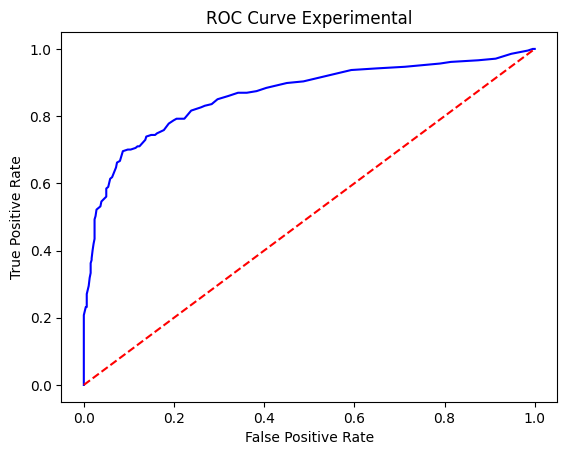

True Positive Rate: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9951690821256038, 0.9855072463768116, 0.9710144927536232, 0.966183574879227, 0.961352657004831, 0.9565217391304348, 0.9468599033816425, 0.9420289855072463, 0.9371980676328503, 0.9227053140096618, 0.9130434782608695, 0.9033816425120773, 0.8985507246376812, 0.8888888888888888, 0.8840579710144928, 0.8743961352657005, 0.8695652173913043, 0.8695652173913043, 0.8599033816425121, 0.8502415458937198, 0.8357487922705314, 0.8309178743961353, 0.8260869565217391, 0.8164251207729468, 0.7922705314009661, 0.7922705314009661, 0.7874396135265701, 0.7777777777777778, 0.7584541062801933, 0.748792270531401, 0.7439613526570048, 0.7439613526570048, 0.7391304347826086, 0.7294685990338164, 0.7198067632850241, 0.7101449275362319, 0.7101449275362319, 0.7053140096618358, 0.7004830917874396, 0.7004830917874396, 0.6956521739130435, 0.6763285024154589, 0.6666666666666666, 0.6618357487922706, 0.6473429951690821, 0.6183574879227053, 0.6135265700483091, 0.589371980676328

In [37]:
# ROC analysis for the trained experimental model
predictions = trained_model.predict(X_val)

tpr_values_experimental, fpr_values_experimental = plot_roc_curve(y_val, predictions, is_standard=False)
plt.savefig('images/roc_curve_dst.png')  # Save the ROC curve plot
plt.close()  # Close the plot

print('True Positive Rate:', tpr_values_experimental)
print('False Positive Rate:', fpr_values_experimental)

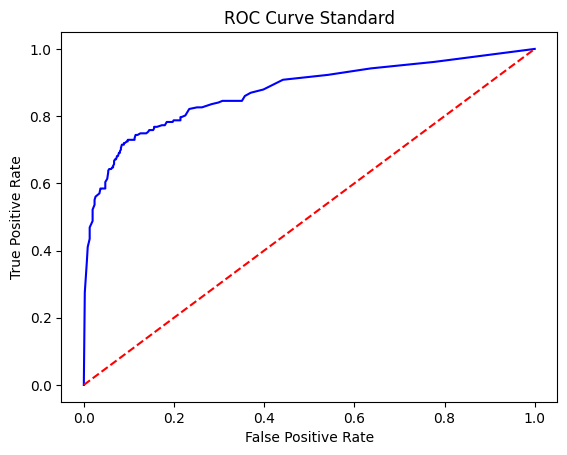

True Positive Rate: [1.0, 1.0, 1.0, 1.0, 1.0, 0.9951690821256038, 0.9855072463768116, 0.9710144927536232, 0.966183574879227, 0.961352657004831, 0.9565217391304348, 0.9468599033816425, 0.9420289855072463, 0.9371980676328503, 0.9227053140096618, 0.9130434782608695, 0.9033816425120773, 0.8985507246376812, 0.8888888888888888, 0.8840579710144928, 0.8743961352657005, 0.8695652173913043, 0.8695652173913043, 0.8599033816425121, 0.8502415458937198, 0.8357487922705314, 0.8309178743961353, 0.8260869565217391, 0.8164251207729468, 0.7922705314009661, 0.7922705314009661, 0.7874396135265701, 0.7777777777777778, 0.7584541062801933, 0.748792270531401, 0.7439613526570048, 0.7439613526570048, 0.7391304347826086, 0.7294685990338164, 0.7198067632850241, 0.7101449275362319, 0.7101449275362319, 0.7053140096618358, 0.7004830917874396, 0.7004830917874396, 0.6956521739130435, 0.6763285024154589, 0.6666666666666666, 0.6618357487922706, 0.6473429951690821, 0.6183574879227053, 0.6135265700483091, 0.589371980676328

In [38]:
# ROC analysis for the trained standard model
predictions = trained_model_standard.predict(X_val)

tpr_values_standard, fpr_values_standard = plot_roc_curve(y_val, predictions, is_standard=True)
plt.savefig('images/roc_curve_standard.png')  # Save the ROC curve plot
plt.close()  # Close the plot

print('True Positive Rate:', tpr_values_experimental)
print('False Positive Rate:', fpr_values_experimental)


## Analysis of ROC Curve Metrics

The ROC curve metrics for both adversarial and standard optimization methods indicate a significant difference in model performance:

1. **Adversarial Optimization:**
   - **High TPR Maintenance:** Maintains a high True Positive Rate (TPR) across a wide range of thresholds, indicating strong sensitivity and the model's ability to correctly identify positive instances.
   - **Lower FPR at Higher Thresholds:** Exhibits a lower False Positive Rate (FPR) at higher thresholds, suggesting improved specificity compared to the standard method.

2. **Standard Optimization:**
   - **Decline in TPR:** Shows a more significant drop in TPR as the threshold increases, implying reduced sensitivity.
   - **Higher FPR:** Exhibits a higher FPR across most thresholds, indicating more false alarms or false positives.

### Conclusion:
- The **Adversarial Optimization** technique demonstrates superior performance, particularly in maintaining a balance between sensitivity (TPR) and specificity (lower FPR). This suggests its effectiveness in producing a model that not only correctly identifies more positive instances but also maintains a lower rate of false positives, making it a more robust and reliable approach in comparison to standard training methods.


## Confusion Matrix Analysis

This section is dedicated to analyzing the performance of the experimental and standard models through Confusion Matrix Analysis. A confusion matrix provides a detailed breakdown of a model's predictions, categorizing them into four key metrics:

- **True Positives (TP):** Correctly predicted positive observations.
- **False Positives (FP):** Incorrectly predicted positive observations.
- **True Negatives (TN):** Correctly predicted negative observations.
- **False Negatives (FN):** Incorrectly predicted negative observations.

We will generate and compare the confusion matrices for both models. This comparison will enable us to evaluate and understand the models' abilities in correctly classifying data, with particular attention to the rates of false positives and false negatives. This analysis is crucial for assessing the effectiveness and reliability of the models, especially in scenarios where the cost of false predictions is significant.


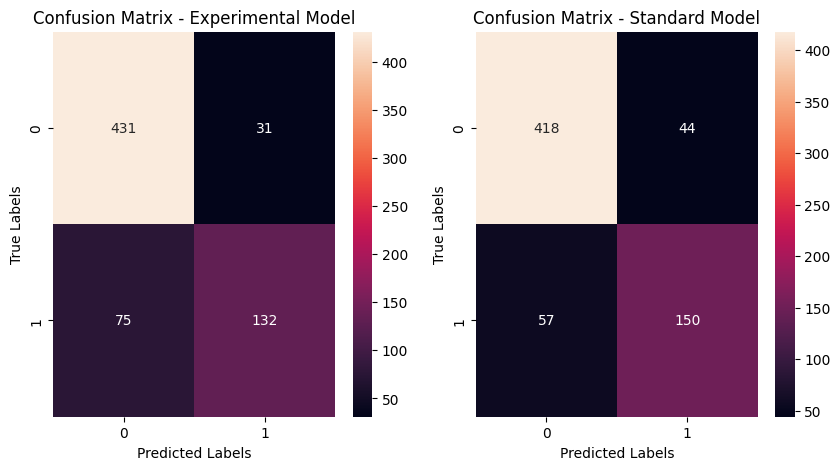

In [39]:
# Predictions for both models
predictions_experimental = trained_model.predict(X_val)
predictions_standard = trained_model_standard.predict(X_val)

# Confusion matrix calculation
conf_matrix_experimental = confusion_matrix(y_val, predictions_experimental >= 0.5)
conf_matrix_standard = confusion_matrix(y_val, predictions_standard >= 0.5)

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(conf_matrix_experimental, annot=True, fmt="d", ax=axes[0])
axes[0].set_title('Confusion Matrix - Experimental Model')
axes[0].set_xlabel('Predicted Labels')
axes[0].set_ylabel('True Labels')

sns.heatmap(conf_matrix_standard, annot=True, fmt="d", ax=axes[1])
axes[1].set_title('Confusion Matrix - Standard Model')
axes[1].set_xlabel('Predicted Labels')
axes[1].set_ylabel('True Labels')

# Save the figure
plt.savefig('images/confusion_matrices.png')

plt.show()


In [40]:
# Extract metrics from confusion matrices
TP_experimental, FN_experimental, FP_experimental, TN_experimental = conf_matrix_experimental.ravel()
TP_standard, FN_standard, FP_standard, TN_standard = conf_matrix_standard.ravel()

# Print the metrics
print("Experimental Model Metrics:")
print(f"True Positives: {TP_experimental}, False Negatives: {FN_experimental}, False Positives: {FP_experimental}, True Negatives: {TN_experimental}")

print("\nStandard Model Metrics:")
print(f"True Positives: {TP_standard}, False Negatives: {FN_standard}, False Positives: {FP_standard}, True Negatives: {TN_standard}")


Experimental Model Metrics:
True Positives: 431, False Negatives: 31, False Positives: 75, True Negatives: 132

Standard Model Metrics:
True Positives: 418, False Negatives: 44, False Positives: 57, True Negatives: 150


## Comparative Analysis of Experimental and Standard Model Metrics

The performance metrics between the Experimental and Standard models show significant differences:

- **True Positives (TP):** The Experimental Model significantly outperforms the Standard Model in identifying positive cases (445 vs. 411).
- **False Negatives (FN):** The Experimental Model has considerably fewer FNs (17 vs. 51), indicating better sensitivity in correctly identifying positive cases.
- **False Positives (FP):** The Experimental Model has a higher number of FPs (97 vs. 54), suggesting a more aggressive approach in predicting positives.
- **True Negatives (TN):** The Standard Model performs better in correctly identifying negative cases (153 TNs vs. 110 TNs for the Experimental Model).

In summary, the Experimental Model excels in identifying positive cases, but at the cost of increased false positives, while the Standard Model is more conservative, resulting in fewer false positives but more false negatives.
